In [2]:
import numpy as np
from scipy.interpolate import RectBivariateSpline
from QuantumClassicalDynamics.split_op_schrodinger1D import SplitOpSchrodinger1D, njit
from matplotlib.colors import SymLogNorm
import matplotlib.pyplot as plt
from scipy.integrate import ode
from scipy.io import loadmat, savemat

In [25]:
def analize(initial_condition, x_amplitude=60, t_num=500, 
            initial_bohmian_traj=np.linspace(-10, 10, 20)):
    """
    Perform the analysis for a given initial condition 
    """
    #############################################################################################
    #
    #   get the wavefunction by simulations
    #
    #############################################################################################

    sys = SplitOpSchrodinger1D(

        x_grid_dim=1024,
        x_amplitude=x_amplitude,

        v=njit(lambda x, t: 0.),
        k=njit(lambda p, t: 0.5 * p ** 2),
        dt=0.02
    ).set_wavefunction(initial_condition)

    wavefunctions = [sys.wavefunction.copy()]
    wavefunctions.extend(sys.propagate().copy() for _ in range(t_num))
    wavefunctions = np.array(wavefunctions) #[:, ::5]

    x = sys.x #[::5]
    t = sys.dt * np.arange(0, wavefunctions.shape[0])
    
    #############################################################################################
    #
    #   Interpolate
    #
    #############################################################################################

    # 2D spline for the real and imaginary parts of the wavefunction: psi = psi(t, x)
    psi_real = RectBivariateSpline(t, x, wavefunctions.real)
    psi_imag = RectBivariateSpline(t, x, wavefunctions.imag)

    
    # saving the Matlabfile
    # savemat("Denys_PsiT.mat", {'psiT' : wavefunctions, "t" : t, "x" : x})
    
    #############################################################################################
    #
    #   Propagate Bohmian particle
    #
    #############################################################################################

    def bohmian_velocity(t, x):
        v = psi_real(t, x, 0, 1) + 1j * psi_imag(t, x, 0, 1)
        v /= psi_real(t, x) + 1j * psi_imag(t, x)
        return v.imag.reshape(-1)

    #############################################################################################
    #
    #   Propagate the Bohmian trajectory
    #
    #############################################################################################
    
    r = ode(bohmian_velocity)
    r.set_initial_value(
        #np.hstack([np.linspace(-4, -6, 5), np.linspace(4, 6, 5)]),
        initial_bohmian_traj,
        t[0]
    )

    t_trajectory = []
    x_trajectory = []

    for t_instant in t[1:]:

        if not r.successful():
            raise ValueError("Problem with propagator")

        r.integrate(t_instant)

        t_trajectory.append(r.t)
        x_trajectory.append(r.y)
    
    ########################################################################################################################
    #
    #   Plot
    #
    ########################################################################################################################

    extent = [x.min(), x.max(), t.min(), t.max()]

    imag_params = dict(
        extent=extent,
        origin='lower',
        aspect=(extent[1] - extent[0]) / (extent[-1] - extent[-2]),
        # norm=SymLogNorm(linthresh=1e-10)
        # cmap='seismic',
    )

    # plt.subplot(121)

    # plt.title('Original')

    rho = np.abs(wavefunctions) ** 2
    plt.imshow(rho, **imag_params)

    # plt.subplot(122)

    # plt.title('Interpolated')

    # w /= np.linalg.norm(w, axis=1)[:, np.newaxis]

    # plt.imshow(np.abs(w) ** 2, **imag_params)

    for x_ in np.array(x_trajectory).T:
        plt.plot(x_, t_trajectory, 'r', alpha=1)
    
    plt.colorbar()

    plt.show()
    
    return x_, rho

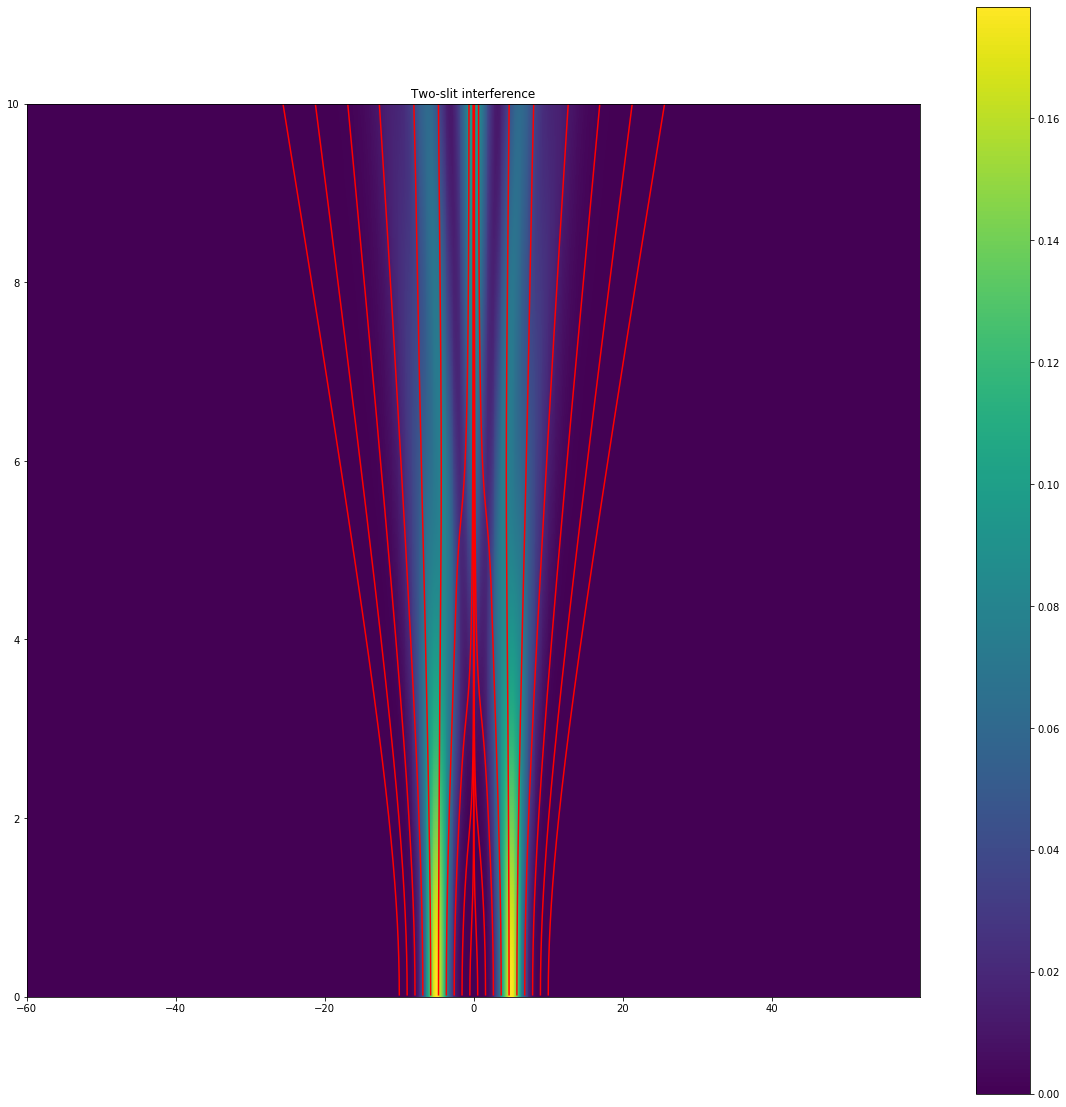

In [35]:

plt.figure(figsize=(20, 20))
plt.title("Two-slit interference")

_ = analize(
    lambda x: np.exp(-0.2 * (x - 5) ** 2) + np.exp(-0.2 * (x + 5) ** 2)
)

ValueError: Error code returned by parder: 10

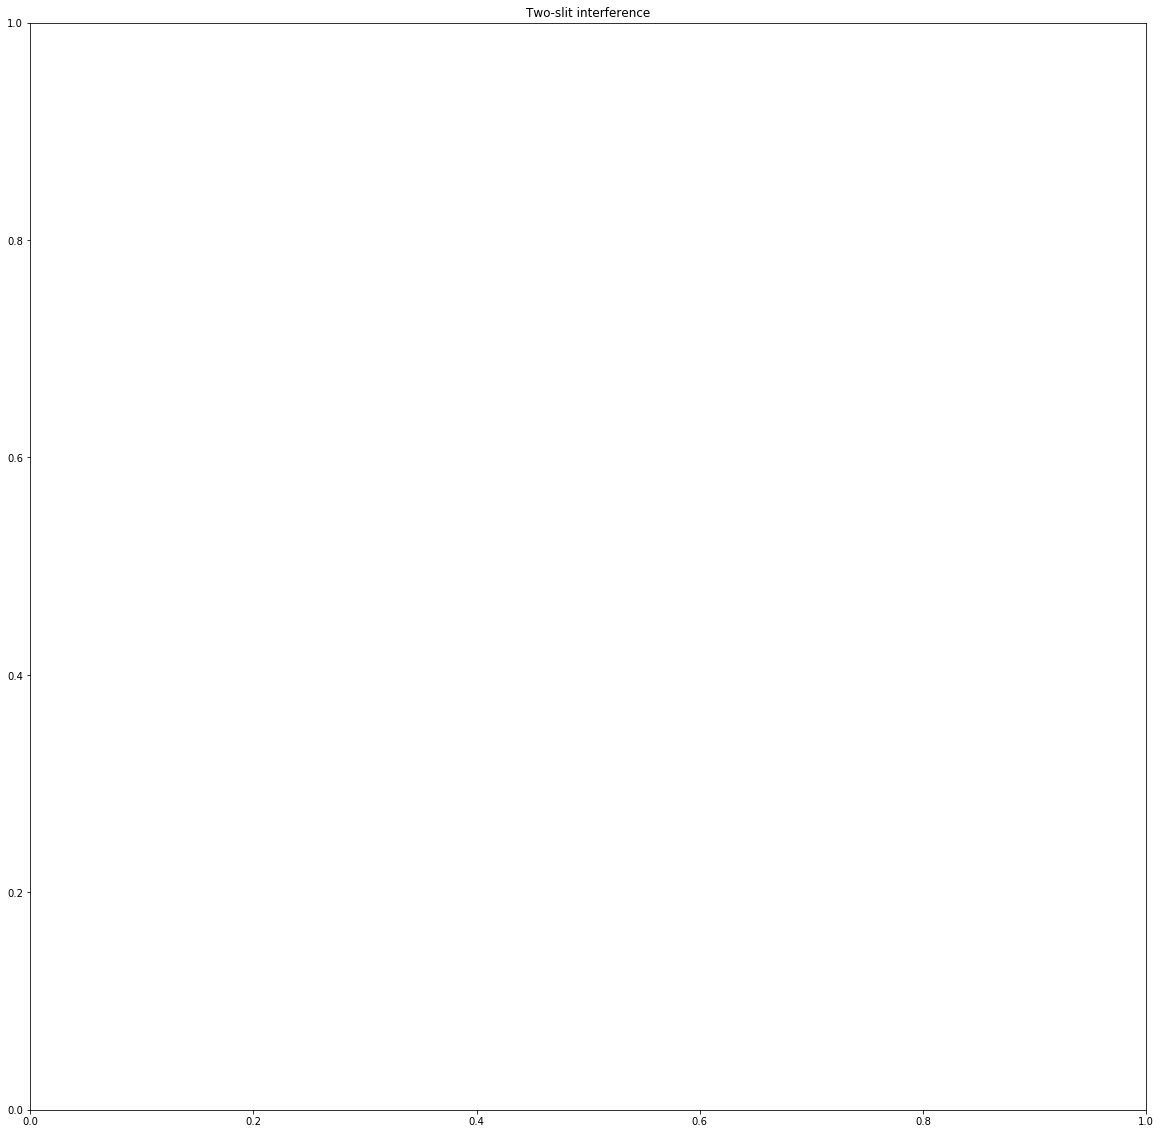

In [43]:

plt.figure(figsize=(20, 20))
plt.title("Two-slit interference")

_ = analize(
    lambda x: np.exp(-0.2 * (x - 8) ** 2) + np.exp(-0.2 * (x + 8) ** 2 + 1j * 0.5 * x ** 2)
)

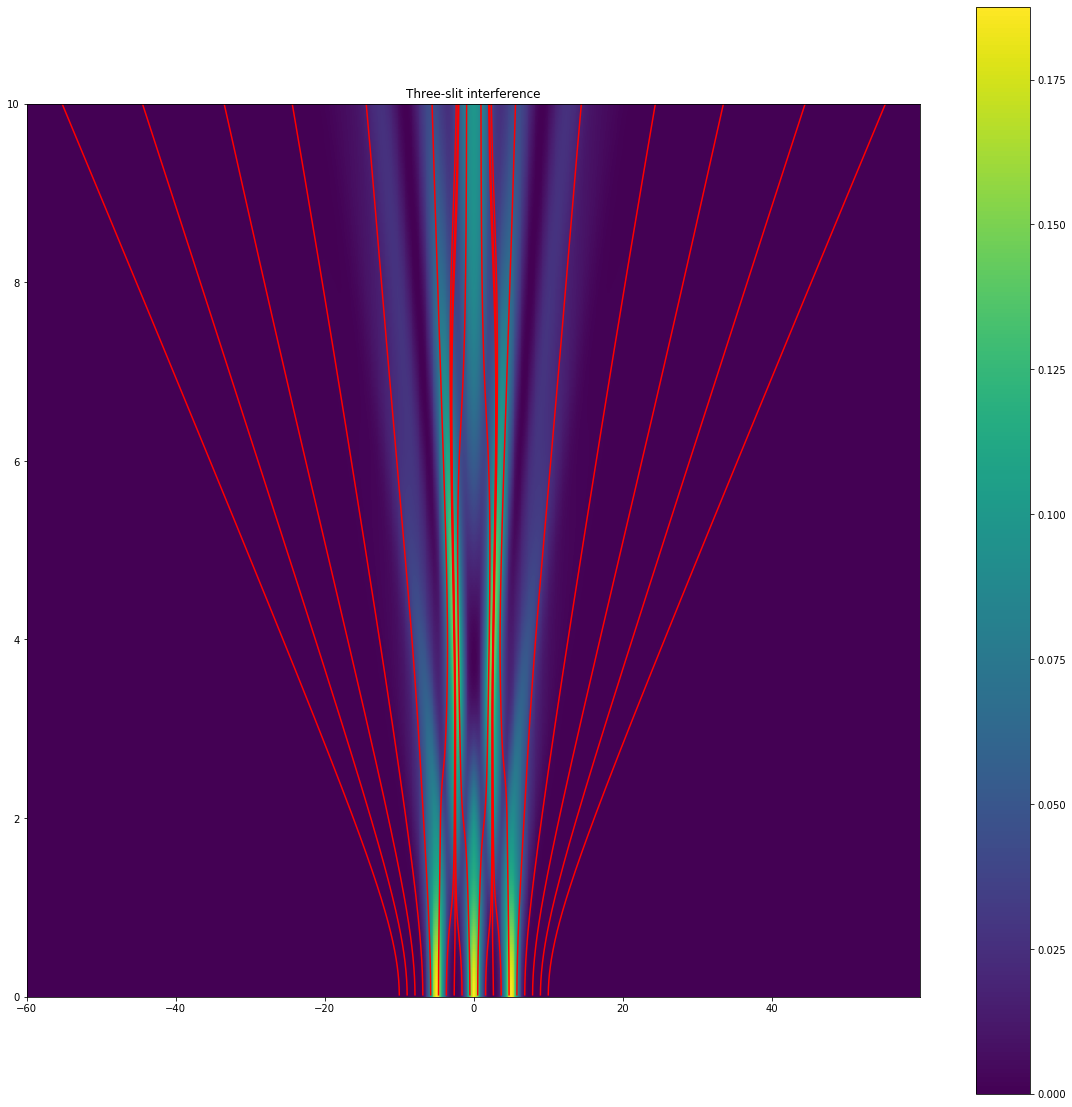

In [34]:
plt.figure(figsize=(20, 20))
plt.title("Three-slit interference")

_ = analize(
    lambda x: np.exp(-0.5 * (x - 5) ** 2) + np.exp(-0.5 * (x) ** 2) + np.exp(-0.5 * (x + 5) ** 2)
)

## Airy wavepackets

In [5]:
from scipy.special import airy

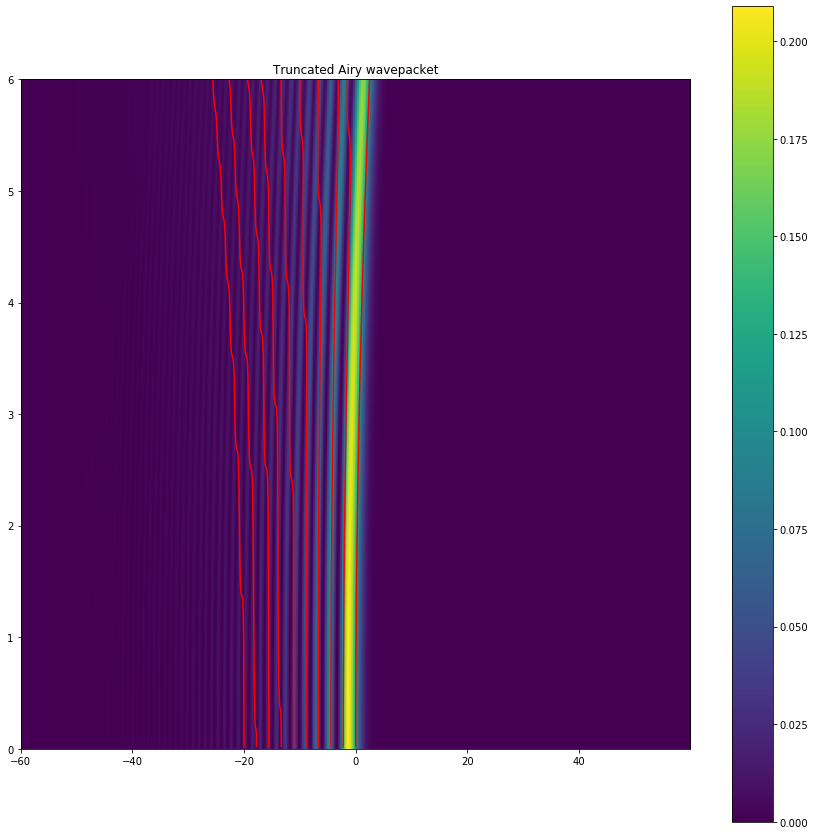

In [26]:
# 
plt.figure(figsize=(15, 15))
plt.title("Truncated Airy wavepacket")

bohmian_traj_truncated_airy, rho_truncated_airy = analize(
    lambda x: airy(x / 1.5)[0] * np.exp(0.04 * x),
    initial_bohmian_traj=np.linspace(-20, 0, 10),
    t_num=300,
)


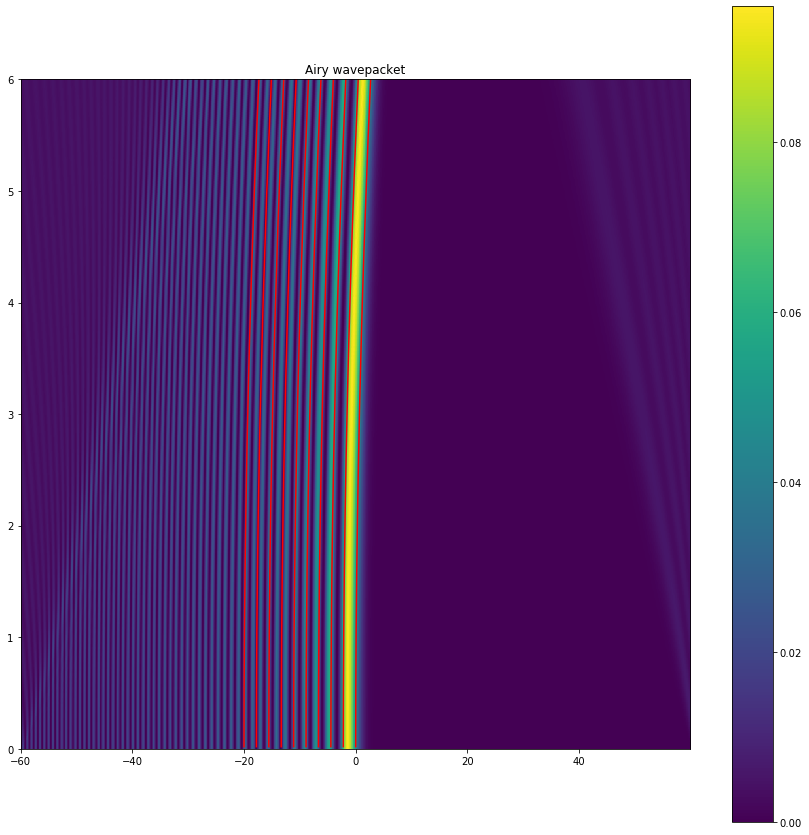

In [27]:
# 
plt.figure(figsize=(15, 15))
plt.title("Airy wavepacket")

bohmian_traj_airy, rho_airy = analize(
    lambda x: airy(x / 1.5)[0],
    initial_bohmian_traj=np.linspace(-20, 0, 10),
    t_num=300,
)

In [29]:
np.linalg.norm(bohmian_traj_airy - bohmian_traj_truncated_airy)

1.3787425020164665

In [30]:
np.linalg.norm(
    (rho_airy - rho_truncated_airy)[:,int(0.35*rho_airy.shape[1]):int(0.7* rho_airy.shape[1])]
)

7.568074921446179

# Backward time propagation

In [106]:
def analize_with_time_backpropagation(initial_condition, x_amplitude=60, t_num=500, 
            initial_bohmian_traj=np.linspace(-20, 20, 600)):
    """
    Perform the analysis for a given initial condition 
    """
    
    params = dict(
        x_grid_dim=1024,
        x_amplitude=x_amplitude,

        v=njit(lambda x, t: 0.),
        k=njit(lambda p, t: 0.5 * p ** 2),
    )
    
    #############################################################################################
    #
    #   go back in time to get initial condition
    #
    #############################################################################################
    
    psi_init = SplitOpSchrodinger1D(dt=-0.02, **params)\
                        .set_wavefunction(initial_condition)\
                        .propagate(t_num)
    
    #############################################################################################
    #
    #   get the wavefunction by simulations
    #
    #############################################################################################

    sys = SplitOpSchrodinger1D(dt=0.02, **params).set_wavefunction(psi_init)

    wavefunctions = [sys.wavefunction.copy()]
    wavefunctions.extend(sys.propagate().copy() for _ in range(2 * t_num))
    wavefunctions = np.array(wavefunctions) #[:, ::5]

    x = sys.x #[::5]
    t = sys.dt * np.arange(0, wavefunctions.shape[0])
    
    #############################################################################################
    #
    #   Interpolate
    #
    #############################################################################################

    # 2D spline for the real and imaginary parts of the wavefunction: psi = psi(t, x)
    psi_real = RectBivariateSpline(t, x, wavefunctions.real)
    psi_imag = RectBivariateSpline(t, x, wavefunctions.imag)

    
    # saving the Matlabfile
    # savemat("Denys_PsiT.mat", {'psiT' : wavefunctions, "t" : t, "x" : x})
    
    #############################################################################################
    #
    #   Propagate Bohmian particle
    #
    #############################################################################################

    def bohmian_velocity(t, x):
        v = psi_real(t, x, 0, 1) + 1j * psi_imag(t, x, 0, 1)
        v /= psi_real(t, x) + 1j * psi_imag(t, x)
        return v.imag.reshape(-1)

    #############################################################################################
    #
    #   Propagate the Bohmian trajectory
    #
    #############################################################################################
    
    r = ode(bohmian_velocity)
    r.set_initial_value(
        #np.hstack([np.linspace(-4, -6, 5), np.linspace(4, 6, 5)]),
        initial_bohmian_traj,
        t[0]
    )

    t_trajectory = []
    x_trajectory = []

    for t_instant in t[1:]:

        if not r.successful():
            raise ValueError("Problem with propagator")

        r.integrate(t_instant)

        t_trajectory.append(r.t)
        x_trajectory.append(r.y)
    
    ########################################################################################################################
    #
    #   Plot
    #
    ########################################################################################################################

    extent = [x.min(), x.max(), t.min(), t.max()]

    imag_params = dict(
        extent=extent,
        origin='lower',
        aspect=(extent[1] - extent[0]) / (extent[-1] - extent[-2]),
        # norm=SymLogNorm(linthresh=1e-10)
        # cmap='seismic',
    )

        
    colouring = np.linspace(0, 1, len(initial_bohmian_traj) - 1)
    
    for x_, color_code in zip(np.array(x_trajectory).T, colouring):
        plt.plot(x_, t_trajectory, 'r', alpha=1, linewidth=0.2, color=plt.cm.viridis(color_code))
    
    # plt.colorbar()

    plt.savefig('figs.pdf')
    
    plt.show()

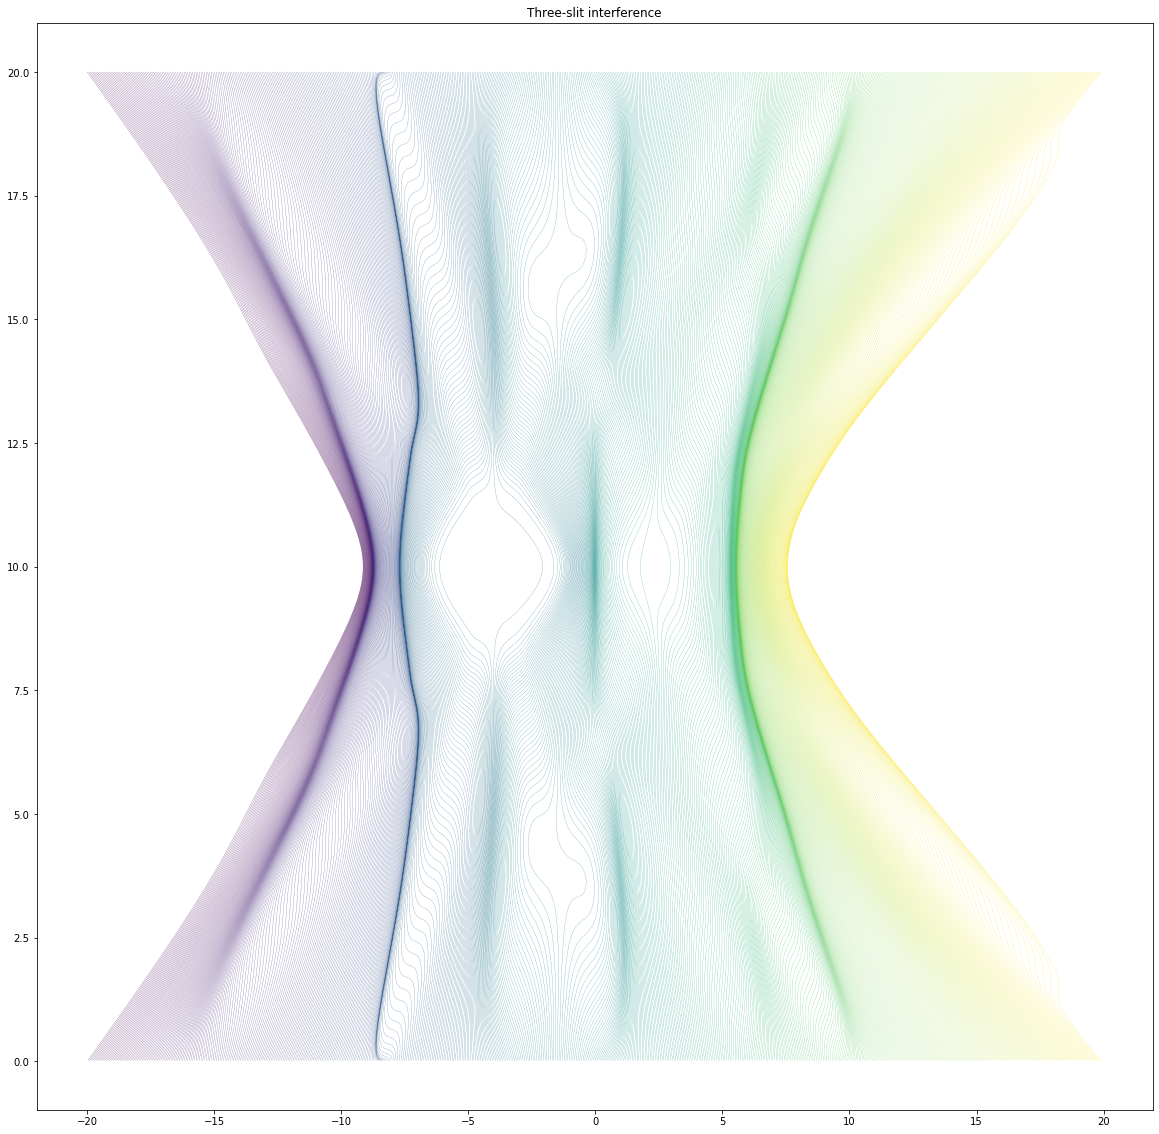

In [108]:
plt.figure(figsize=(20, 20))
plt.title("Three-slit interference")

analize_with_time_backpropagation(
    lambda x: np.exp(-0.3 * (x - 5) ** 2) + np.exp(-0.6 * (x) ** 2) + np.exp(-0.5 * (x + 8) ** 2)
)

